In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities, plot_recall, recall_given_dist, plot_topk
from PIL import Image
seaborn.set()

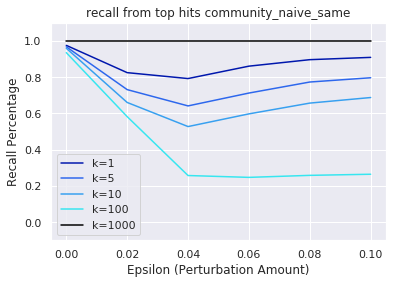

In [2]:
plot_recall(
    path_to_adversarial="/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5",
    path_to_clean="/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5",
    epsilons=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1],
    identities=read_sampled_identities("../sampled_identities.txt").keys(),
    ks=[1, 5, 10, 100, 1000],
    colors=['#0017ad', '#2d67ed', '#37a0f0', '#37e6f0','#000000']
)

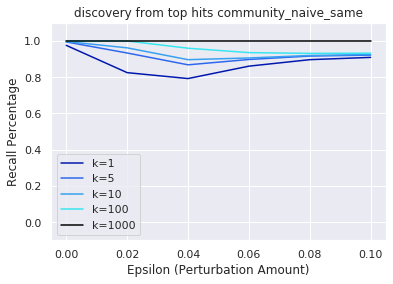

In [3]:
plot_recall(
    path_to_adversarial="/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5",
    path_to_clean="/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5",
    epsilons=[0.0, 0.02, 0.04, 0.06, 0.08, 0.1],
    identities=read_sampled_identities("../sampled_identities.txt").keys(),
    ks=[1, 5, 10, 100, 1000],
    colors=['#0017ad', '#2d67ed', '#37a0f0', '#37e6f0','#000000'],
    mode="discovery"
)

# Tests for recall function

In [4]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 100) == 1.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 2) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 2) == 0.5)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 2) == 0.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 4) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 4) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 4) == 1.0)
print()
print(np.abs(recall_given_dist([0.0, 1.8], [1.5, 1.6], 3) - 0.5) < 1e-3)
print(np.abs(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3)) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 3)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 3) == 0.5)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 1)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 1) == 0.0)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 5) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 5)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 5)) == 0.8)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 1)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 1)) == 1.0)

True
True
True

True
True
True

True

True
True

True
True
True

True

True
True

True
True
True

True
True
True

True
True
True

True
True
True

True
True
True


TypeError: recall_given_dist() takes 3 positional arguments but 4 were given

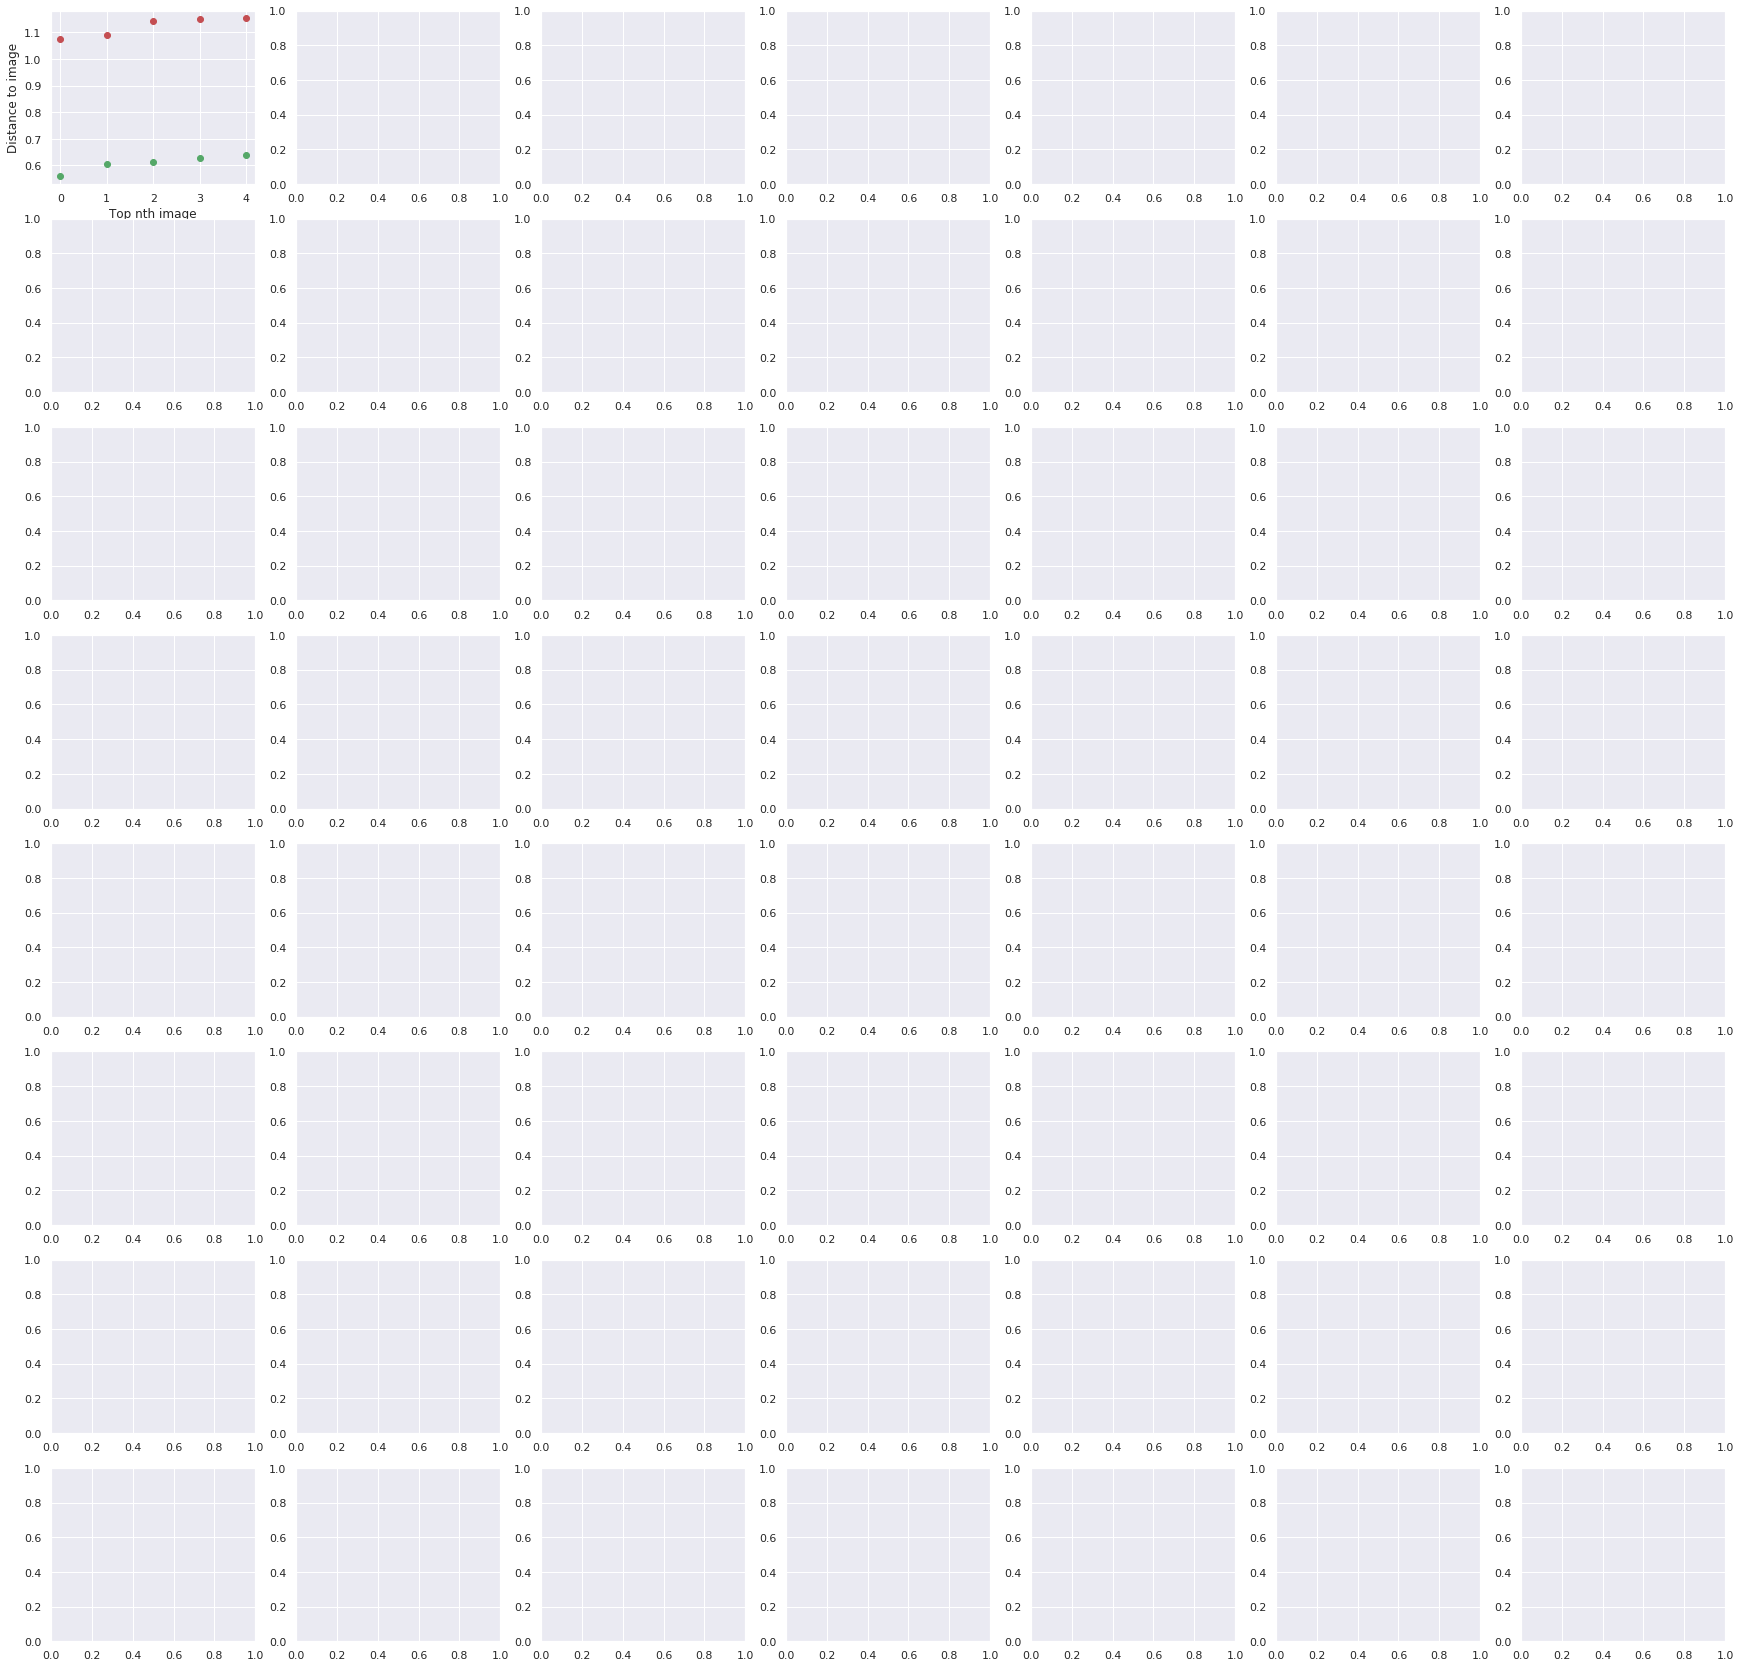

In [5]:
plot_topk()

In [ ]:
plot_topk(k=5, epsilon=0.1)

In [ ]:
plot_topk(adversarial_target="n005359", epsilon=0.04)

In [ ]:
plot_topk(adversarial_target="n005359", epsilon=0.04, k=100)

In [ ]:
plot_topk(adversarial_target="n005359", epsilon=0.04, k=10)